In [35]:
import numpy as np
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
# MLE Classifier
class MLEClassifier:
    def __init__(self):
        self.classes = None
        self.class_priors = None
        self.class_conditional_means = None
        self.class_conditional_covs = None
        self.reg_covar = 1e-6
    def ident(self):
        return "MLE classifier"
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_priors = np.zeros(len(self.classes))
        self.class_conditional_means = np.zeros((len(self.classes), X.shape[1]))
        self.class_conditional_covs = np.zeros((len(self.classes), X.shape[1], X.shape[1]))
        
        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_priors[i] = len(X_c) / len(X)
            self.class_conditional_means[i] = np.mean(X_c, axis=0)
            self.class_conditional_covs[i] = np.cov(X_c.T) + self.reg_covar * np.eye(X.shape[1])   
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_priors = np.zeros(len(self.classes))
        self.class_conditional_means = np.zeros((len(self.classes), X.shape[1]))
        self.class_conditional_covs = np.zeros((len(self.classes), X.shape[1], X.shape[1]))
        
        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_priors[i] = len(X_c) / len(X)
            self.class_conditional_means[i] = np.mean(X_c, axis=0)
            self.class_conditional_covs[i] = np.cov(X_c.T) + self.reg_covar * np.eye(X.shape[1])
            
    def predict(self, X):
        y_pred = []
        
        for x in X:
            class_scores = []
            
            for i, c in enumerate(self.classes):
                class_score = np.log(self.class_priors[i])
                try:
                    class_score += multivariate_normal.logpdf(x, 
                                                          mean=self.class_conditional_means[i], 
                                                          cov=self.class_conditional_covs[i])
                except:
                    print(f"x: {x}")
                    print(f"cov: {self.class_conditional_covs[i]}")
                    assert 0

                class_scores.append(class_score)
            
            y_pred.append(self.classes[np.argmax(class_scores)])
        
        return np.array(y_pred)

class NaiveBayesClassifier:
    def __init__(self):
        self.classes = None
        self.class_priors = None
        self.class_conditional_means = None
        self.class_conditional_vars = None
    def ident(self):
        return "Naive Bayes classifier"
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_priors = np.zeros(len(self.classes))
        self.class_conditional_means = np.zeros((len(self.classes), X.shape[1]))
        self.class_conditional_vars = np.zeros((len(self.classes), X.shape[1]))
        
        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_priors[i] = len(X_c) / len(X)
            self.class_conditional_means[i] = np.mean(X_c, axis=0)
            self.class_conditional_vars[i] = np.var(X_c, axis=0)
            
    def predict(self, X):
        y_pred = []
        
        for x in X:
            class_scores = []
            
            for i, c in enumerate(self.classes):
                class_score = np.log(self.class_priors[i])
                class_score += np.sum(norm.logpdf(x, 
                                                  loc=self.class_conditional_means[i], 
                                                  scale=np.sqrt(self.class_conditional_vars[i])))
                class_scores.append(class_score)
            
            y_pred.append(self.classes[np.argmax(class_scores)])
        
        return np.array(y_pred)
    
class KNNClassifier:
    def __init__(self, k=3, norm=2):
        self.k = k
        self.norm = norm
        self.X = None
        self.y = None
    def ident(self):
        return f"{self.k}-NN classifier ({self.norm}-norm)" 
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X):
        y_pred = []
        
        for x in X:
            distances = cdist(self.X, [x], metric='minkowski', p=self.norm)
            neighbors = self.y[np.argsort(distances.ravel())[:self.k]]
            unique, counts = np.unique(neighbors, return_counts=True)
            y_pred.append(unique[np.argmax(counts)])
        
        return np.array(y_pred)
    



def plot_class_predictions(array1, array2, title):
    # Plot the arrays as a scatter plot
    plt.scatter(np.arange(len(array1)), array1, c='r', label='Race 0')
    plt.scatter(np.arange(len(array2)), array2, c='b', marker='x', label='Race 1')

    # Set the x-axis and y-axis labels
    plt.xlabel('Class')
    plt.ylabel('Prediction Level')

    # Set the title of the plot
    plt.title(title)

    # Add a legend to the plot
    plt.legend()

    # Display the plot
    plt.show()



In [ ]:
# Load train and test data from CSV files
train_data = np.loadtxt("propublicaTrain.csv", 
                        delimiter=",", 
                        skiprows=1, 
                        usecols=(1,2,3,4,5,6,7,8,9))
train_labels = np.loadtxt("propublicaTrain.csv", delimiter=",", skiprows=1, usecols=(0,))
test_data = np.loadtxt("propublicaTest.csv", delimiter=",", skiprows=1, usecols=(1,2,3,4,5,6,7,8,9))
test_labels = np.loadtxt("propublicaTest.csv", delimiter=",", skiprows=1, usecols=(0,))

classifier = MLEClassifier()
classifier.fit(train_data, train_labels)
y_pred = classifier.predict(test_data)
accuracy = np.mean(y_pred == test_labels)
print(f"MLE accuracy: {accuracy}")

classifier = NaiveBayesClassifier()
classifier.fit(train_data, train_labels)
y_pred = classifier.predict(test_data)
accuracy = np.mean(y_pred == test_labels)
print(f"Naive Bayes accuracy: {accuracy}")

for k in range(1,10):
    for n in [1,2,np.inf]:
        classifier = KNNClassifier(k=3,norm=n)
        classifier.fit(train_data, train_labels)
        y_pred = classifier.predict(test_data)
        accuracy = np.mean(y_pred == test_labels)
        print(f"{k}-NN with {n}-norm accuracy: {accuracy}")


In [26]:

# Define train sizes to use for accuracy vs. size plot
train_sizes = [0.01, 0.02, 0.045, 0.1, 0.2, 0.5, 0.7, 1.0]
avg_iters = 10
# Train and test the classifier for each train size
accuraciesMLE = [0]*len(train_sizes)
accuraciesNB = [0]*len(train_sizes)
accuraciesKNN = [0]*len(train_sizes)

for i, size in enumerate(train_sizes):
    # Select a random subset of the training data
    for _ in range(avg_iters):
        idx = np.random.choice(train_data.shape[0], int(size * train_data.shape[0]), replace=False)
        train_data_subset = train_data[idx]
        #print(f"ds size: {len(train_data_subset)}")
        train_labels_subset = train_labels[idx]
    
        # Train the classifier on the subset of training data
        classifierMLE = MLEClassifier()
        classifierNB = NaiveBayesClassifier()
        classifierKNN = KNNClassifier(k=5,norm=2)
        classifierMLE.fit(train_data_subset, train_labels_subset)
        classifierNB.fit(train_data_subset, train_labels_subset)
        classifierKNN.fit(train_data_subset, train_labels_subset)
    
        # Evaluate the classifier on the test data
        y_predMLE = classifierMLE.predict(test_data)
        accuracyMLE = np.mean(y_predMLE == test_labels)
        y_predNB = classifierNB.predict(test_data)
        accuracyNB = np.mean(y_predNB == test_labels)
        y_predKNN = classifierKNN.predict(test_data)
        accuracyKNN = np.mean(y_predKNN == test_labels)
        
        accuraciesMLE[i] += accuracyMLE
        accuraciesNB[i] += accuracyNB
        accuraciesKNN[i] += accuracyKNN
    accuraciesMLE[i] /= avg_iters
    accuraciesNB[i] /= avg_iters
    accuraciesKNN[i] /= avg_iters



/Users/frederickcunningham/Library/Python/3.8/lib/python/site-packages/scipy/stats/_distn_infrastructure.py:2126: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/frederickcunningham/Library/Python/3.8/lib/python/site-packages/scipy/stats/_distn_infrastructure.py:2126: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


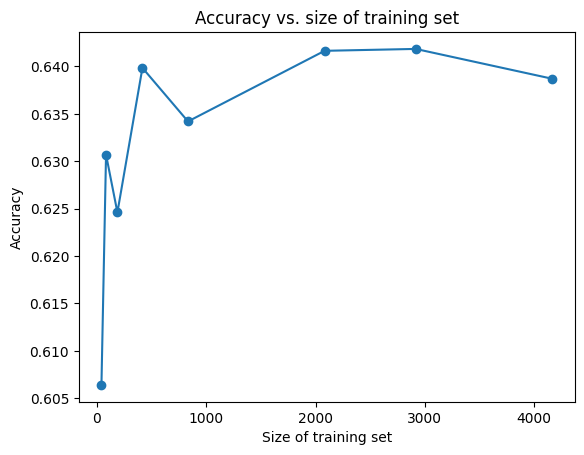

In [27]:
# Plot accuracy vs. size of training set
plt.plot([int(size * train_data.shape[0]) for size in train_sizes], accuraciesKNN, 'o-')
plt.xlabel("Size of training set")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. size of training set")
plt.show()

In [51]:
# Load train and test data from CSV files
train_data = np.loadtxt("propublicaTrain.csv", 
                        delimiter=",", 
                        skiprows=1, 
                        usecols=(1,2,3,4,5,6,7,8,9))
train_labels = np.loadtxt("propublicaTrain.csv", delimiter=",", skiprows=1, usecols=(0,))
test_data = np.loadtxt("propublicaTest.csv", delimiter=",", skiprows=1, usecols=(1,2,3,4,5,6,7,8,9))
test_labels = np.loadtxt("propublicaTest.csv", delimiter=",", skiprows=1, usecols=(0,))

sens = []
sens_labs = []
for i in range(2):
    idxs = test_data[:,2] == i
    sens_only = test_data[idxs]
    sens_lab = test_labels[idxs]
    
    sens.append(sens_only)
    sens_labs.append(sens_lab)
    
classifiers = [MLEClassifier(), NaiveBayesClassifier(), KNNClassifier(k=5,norm=2)]
for clfyer in classifiers:
    clfyer.fit(train_data, train_labels)
    print("Demographic parity:\n")
    p0 = np.mean(clfyer.predict(sens[0]))
    p1 = np.mean(clfyer.predict(sens[1]))
    print(f"{clfyer.ident()} predicts {p0} for race 0, {p1} for race 1")
    print("Equalized odds:\n")
    for c in range(2):
        for i, sens_set in enumerate(sens):
            
            
            idxs = sens_labs[i]==c
            
            data = sens[i][idxs]
            p = np.mean(clfyer.predict(data))
            print(f"{clfyer.ident()} predicts {p} for race {i} given ground truth {c}")

    print("Predictive parity:\n")
    for c in range(2):
        for i, sens_set in enumerate(sens):
            
            predictions = clfyer.predict(sens_set)
            
            idxs = predictions==c
            
            p = np.mean(sens_labs[i][idxs]==c)

            print(f"{clfyer.ident()} predicts {p} of gt class {c} as {c} given race {i}")




Demographic parity:

MLE classifier predicts 0.19835329341317365 for race 0, 0.09789156626506024 for race 1
Equalized odds:

MLE classifier predicts 0.08284883720930232 for race 0 given ground truth 0
MLE classifier predicts 0.04466501240694789 for race 1 given ground truth 0
MLE classifier predicts 0.32098765432098764 for race 0 given ground truth 1
MLE classifier predicts 0.18007662835249041 for race 1 given ground truth 1
Predictive parity:

MLE classifier predicts 0.5891690009337068 of gt class 0 as 0 given race 0
MLE classifier predicts 0.6427378964941569 of gt class 0 as 0 given race 1
MLE classifier predicts 0.7849056603773585 of gt class 1 as 1 given race 0
MLE classifier predicts 0.7230769230769231 of gt class 1 as 1 given race 1
Demographic parity:

Naive Bayes classifier predicts 0.20209580838323354 for race 0, 0.09487951807228916 for race 1
Equalized odds:

Naive Bayes classifier predicts 0.08284883720930232 for race 0 given ground truth 0
Naive Bayes classifier predicts 0.

In [31]:
import numpy as np

# create 2d numpy array
arr = np.array([[1, 2, 1], [4, 5, 0], [7, 8, 1]])

# filter rows where the third element is equal to 1
filtered_arr = arr[arr[:, 1] == 2]

print(filtered_arr)

[[1 2 1]]
